# HARDER LASSO MCP

In [24]:
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent.parent.parent.parent)+"\AYMEN\EXPLORATION\CAS LINEAIRE\OUTILS")

## Théorie

$$
\boxed{
  \min_{\beta \in \mathbb{R}^{p}}
  \; \|y - X\beta\|_{2}
  \;+\;
  \lambda \sum_{j=1}^{p} P_{\alpha,\gamma}\!\bigl(|\beta_{j}|\bigr)
}
$$

$$
P_{\alpha,\gamma}(t)=
\begin{cases}
\displaystyle \alpha t-\dfrac{t^{2}}{2\gamma}, & 0\le t\le\gamma\alpha,\\[6pt]
\displaystyle \dfrac{\gamma\alpha^{2}}{2}, & t>\gamma\alpha,
\end{cases}
\qquad(\gamma>1).
$$

$$
\operatorname{prox}_{\tau P_{\alpha,\gamma}}(v)=
\begin{cases}
0, & |v|\le \tau\alpha,\\[8pt]
\displaystyle\frac{\operatorname{sign}(v)\bigl(|v|-\tau\alpha\bigr)}{1-\tau/\gamma},
& \tau\alpha<|v|\le\gamma\alpha,\\[12pt]
v, & |v|>\gamma\alpha,
\end{cases}
\quad\text{pour }\tau\in(0,\gamma).
$$

## Test

In [ ]:
import numpy as np

def mcp(t, alpha, gamma):
    """
    Pénalité MCP scalaire.
    """
    t = np.abs(t)
    if t <= gamma * alpha:
        return alpha * t - t**2 / (2 * gamma)
    else:
        return 0.5 * gamma * alpha**2

def P_nu(x, nu):
    x = np.asarray(x)
    norm_x = np.abs(x)
    rho = norm_x / (1 + norm_x**(1 - nu))
    return np.sum(rho)

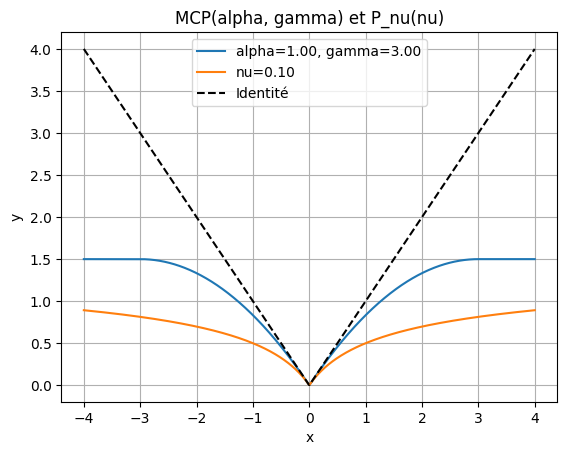

In [67]:
import numpy as np
import matplotlib.pyplot as plt

gamma = 3.0
lmbda = 1.0
nu = 0.1
x_list = np.linspace(-4, 4, 1000)

plt.plot(x_list, [mcp(x, lmbda, gamma) for x in x_list], label=f"alpha={alpha:.2f}, gamma={gamma:.2f}")
plt.plot(x_list, [P_nu(x, nu) for x in x_list], label=f"nu={nu:.2f}")

plt.plot(x_list, np.abs(x_list), '--', color='black', label="Identité")
plt.xlabel("x")
plt.ylabel("y")
plt.title("MCP(alpha, gamma) et P_nu(nu)")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
def prox_mcp(v, alpha, gamma, tau):
    """
    Proximal de MCP scalaire.
    """
    abs_v = np.abs(v)
    sign_v = np.sign(v)

    if abs_v <= tau * alpha:
        return 0.0
    elif abs_v <= gamma * alpha:
        return sign_v * (abs_v - tau * alpha) / (1 - tau / gamma)
    else:
        return v

def F_jump(k, lmbda, nu):
        return k**(2 - nu) + 2*k + k**nu + 2 * lmbda * (nu - 1)

def rho_nu_prime(theta, nu):
    abs_theta = abs(theta)
    denom = (1 + abs_theta**(1 - nu))**2
    return np.sign(theta) * (1 + nu * abs_theta**(1 - nu)) / denom

def drho_nu_prime(theta, nu):
    abs_theta = abs(theta)
    num = nu * (1 - nu) * abs_theta**(-nu)
    denom = (1 + abs_theta**(1 - nu))**3
    return num / denom

def F_theta(theta, z, lmbda, nu):
    return theta - z + lmbda * rho_nu_prime(theta, nu)

def F_theta_prime(theta, z, lmbda, nu):
    return 1 + lmbda * drho_nu_prime(theta, nu)

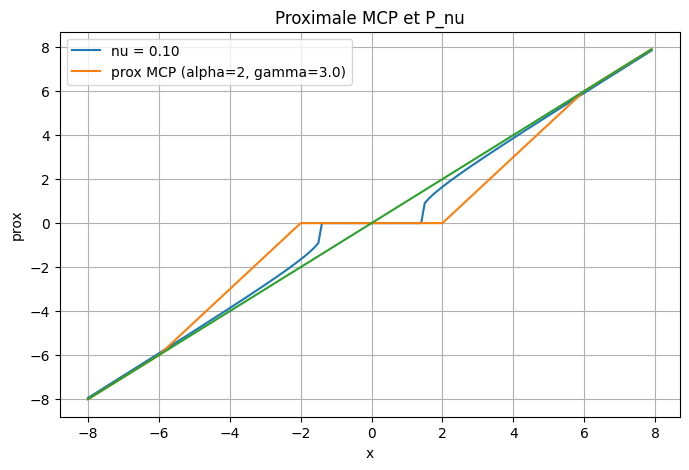

In [43]:
from linear_tools import dichotomie, newton
import numpy as np
import matplotlib.pyplot as plt

x_list = np.arange(-8, 8, 0.1)
lmbda = 2
tau = 1.0
gamma = 3.0
nu = 0.1

plt.figure(figsize=(8, 5))

# Prox P_nu
kappa = dichotomie(F_jump, (lmbda, nu), a=1e-25, b=1e2, tol=1e-6)
phi = 0.5 * kappa + lmbda / (1 + kappa**(1 - nu))
    
y = np.zeros_like(x_list)
for i, x in enumerate(x_list):
    if abs(x) <= phi:
        y[i] = 0.0
    else:
        y[i] = newton(F_theta, F_theta_prime, F_args=(x, lmbda, nu), x0=x, tol=1e-6)

plt.plot(x_list, y, label=f"nu = {nu:.2f}")

# Prox MCP
plt.plot(x_list, [prox_mcp(x, lmbda, gamma, tau) for x in x_list], label=f"prox MCP (alpha={lmbda}, gamma={gamma})")

plt.plot(x_list, x_list)

plt.legend()
plt.title(f"Proximale MCP et P_nu")
plt.xlabel("x")
plt.ylabel("prox")
plt.grid(True)
plt.show()

## Simulation

### Simulateur

In [54]:
import numpy as np
from linear_tools import generate_data, pesr, tpr, fdr, f1, plot_scores, ista, ista_backtracking, cd, qut_lasso_oracle

class SimulationHarderLasso:

    def __init__(self, n, p, list_s, sigma, simu_iter=100, qut_iter=100, max_iter=1000, tol=1e-6, seed=42, verbose=False):

        self.n = n
        self.p = p
        self.list_s = list_s
        self.sigma = sigma

        self.L0 = 10
        self.beta0 = 3

        self.warm_start_len = 7

        self.simu_iter = simu_iter
        self.qut_iter = qut_iter
        self.max_iter = max_iter

        self.tol = tol
        self.seed = seed
        np.random.seed(self.seed)
        np.set_printoptions(precision=3, suppress=True, linewidth=120)

        self.score = self._generate_score_empty()

        self.verbose = verbose

    def _generate_score_empty(self):
        return {
        'pesr': [],
        'f1': [],
        'tpr': [],
        'fdr': []
    }

    def _get_score(self, beta, beta_hat):
        return {
        'pesr': float(pesr(beta, beta_hat)),
        'f1': float(f1(beta, beta_hat)),
        'tpr': float(tpr(beta, beta_hat)),
        'fdr': float(fdr(beta, beta_hat))
    }

    def _generate_data(self, s, seed=False):
        if not seed: seed = self.seed
        return generate_data(n=self.n,
                            p=self.p, 
                            s=s,
                            sigma=self.sigma,
                            beta0=self.beta0,
                            seed=seed)

    def _get_lambda(self, X, alpha=0.05, seed=False):
        if not seed: seed = self.seed
        return qut_lasso_oracle(X=X,
                                sigma=self.sigma,
                                M=self.qut_iter,
                                alpha=alpha,
                                seed=seed)
    
    def _get_lambda_path(self, lmbda_max):
        path = []
        for k in range(self.warm_start_len):
            ratio = np.exp(k) / (1 + np.exp(k))
            lmbda_k = ratio * lmbda_max
            path.append(lmbda_k)
        return path
    
    def _f(self, beta, y, X):
        return np.linalg.norm(y - X @ beta) ** 2
    
    def _g(self, beta, lmbda):
        return lmbda * np.linalg.norm(beta)

    def _grad_f(self, beta, y, X):
        return - 2 * (X.T @ (y - X @ beta))

    def _prox_g(self, z, L, lmbda):
        return  np.sign(z) * np.maximum(np.abs(z) - lmbda / L, 0)

    def _simulation(self, s):

        score = self._generate_score_empty()

        if self.verbose:
            print(f"|{s}| Simulations pour s = {s} :")

        for i in range(self.simu_iter):

            y, X, beta = self._generate_data(s, seed = self.seed + i)

            lmbda = self._get_lambda(X)

            beta_hat = np.zeros(self.p)
            path = self._get_lambda_path(lmbda)

            for lmbda_k in path:

                beta_hat = ista_backtracking(f=self._f,
                                g=self._g,
                                grad_f=self._grad_f,
                                prox_g=self._prox_g,
                                x0=beta_hat,
                                L0=self.L0,
                                f_args=(y, X),
                                g_args=[lmbda_k],
                                grad_f_args=(y, X),
                                prox_g_args=[lmbda_k],
                                max_iter=self.max_iter,
                                tol=self.tol)

            score_tmp = self._get_score(beta, beta_hat)

            for key in score_tmp:
                score[key].append(score_tmp[key])

            if self.verbose:
                print(f"\t |{i+1}| Simulation {i+1}/{self.simu_iter} :")
                #print(f"\t\t beta : {beta}")
                #print(f"\t\t beta estimé : {beta_hat}")
                print(f"\t\t Lambda : {lmbda}")
                print(f"\t\t Score :")
                for key in score_tmp:
                    print(f"\t\t\t{key} : {score_tmp[key]}")

        score_m = self._generate_score_empty()

        for key in score_m:
            score_m[key].append(float(np.mean(score[key])))

        if self.verbose:
            print(f"\t Score :")
            for key in score_m:
                print(f"\t\t{key} : {score_m[key]}")

        return score_m

    def run(self):

        for s in self.list_s:

            score_tmp = self._simulation(s)

            for key in score_tmp:
                self.score[key].append(score_tmp[key])

    def plot(self):

        plot_scores(self.score, self.list_s, f"HARDER LASSO ISTA with backtracking σ={self.sigma}, n={self.n}, p={self.p}, warm start")


In [48]:
import numpy as np
from linear_tools import generate_data, pesr, tpr, fdr, f1, plot_scores, ista_backtracking, qut_square_root_lasso

class SimulationHarderLassoMCP:

    def __init__(self, n, p, list_s, sigma, gamma = None, simu_iter=100, qut_iter=100, max_iter=1000, tol=1e-6, seed=42, verbose=False):

        self.n = n
        self.p = p
        self.list_s = list_s
        self.sigma = sigma

        self.warm_start_len = 7

        self.L0 = 10
        self.beta0 = 3
        self.gamma = gamma or 3.0

        self.simu_iter = simu_iter
        self.qut_iter = qut_iter
        self.max_iter = max_iter

        self.tol = tol
        self.seed = seed
        np.random.seed(self.seed)
        np.set_printoptions(precision=3, suppress=True, linewidth=120)

        self.score = self._generate_score_empty()

        self.verbose = verbose

    def _generate_score_empty(self):
        return {
        'pesr': [],
        'f1': [],
        'tpr': [],
        'fdr': []
    }

    def _get_score(self, beta, beta_hat):
        return {
        'pesr': float(pesr(beta, beta_hat)),
        'f1': float(f1(beta, beta_hat)),
        'tpr': float(tpr(beta, beta_hat)),
        'fdr': float(fdr(beta, beta_hat))
    }

    def _generate_data(self, s, seed=False):
        if seed is False:
            seed = self.seed
        y, X, beta = generate_data(n=self.n,
                            p=self.p, 
                            s=s,
                            sigma=self.sigma,
                            beta0=self.beta0,
                            seed=seed)
        X = X / X.std(axis=0)
        return y, X, beta

    def _get_lambda(self, X, alpha=0.05, seed=False):
        if seed is False:
            seed = self.seed
        return qut_square_root_lasso(X=X,
                                M=self.qut_iter,
                                alpha=alpha,
                                seed=seed)
    
    def _get_lambda_path(self, lmbda_max):
        path = []
        for k in range(self.warm_start_len):
            ratio = np.exp(k) / (1 + np.exp(k))
            lmbda_k = ratio * lmbda_max
            path.append(lmbda_k)
        return path
    
    def _f(self, beta, y, X):
        return np.linalg.norm(y - X @ beta, ord=2)
    
    def _g(self, beta, lmbda, gamma):
        t = np.abs(beta)
        out = np.zeros_like(t)
        mask_1 = t <= gamma * lmbda
        mask_2 = t > gamma * lmbda

        out[mask_1] = lmbda * t[mask_1] - (t[mask_1] ** 2) / (2 * gamma)
        out[mask_2] = 0.5 * gamma * lmbda ** 2
        return np.sum(out)

    def _grad_f(self, beta, y, X):
        r = y - X @ beta
        norm_r = np.linalg.norm(r, ord=2)
        if norm_r == 0:
            return np.zeros_like(beta)
        return -X.T @ r / norm_r

    def _prox_g(self, z, L, lmbda, gamma):
        tau = 1 / L
        abs_z = np.abs(z)
        sign_z = np.sign(z)

        prox = np.zeros_like(z)

        mask_0 = abs_z <= tau * lmbda
        mask_1 = (abs_z > tau * lmbda) & (abs_z <= gamma * lmbda)
        mask_2 = abs_z > gamma * lmbda

        prox[mask_1] = sign_z[mask_1] * (abs_z[mask_1] - tau * lmbda) / (1 - tau / gamma)
        prox[mask_2] = z[mask_2]

        return prox

    def _simulation(self, s):

        score = self._generate_score_empty()

        if self.verbose:
            print(f"|{s}| Simulations pour s = {s} :")

        for i in range(self.simu_iter):

            y, X, beta = self._generate_data(s, seed = self.seed + i)

            lmbda = 1 * self._get_lambda(X)

            beta_hat = np.zeros(self.p)
            path = self._get_lambda_path(lmbda)

            for lmbda_k in path:

                beta_hat = ista_backtracking(
                    f=self._f,
                    g=self._g,
                    grad_f=self._grad_f,
                    prox_g=self._prox_g,
                    x0=beta_hat,
                    L0=self.L0,
                    f_args=(y, X),
                    g_args=[lmbda_k, self.gamma],
                    grad_f_args=(y, X),
                    prox_g_args=[lmbda_k, self.gamma],
                    max_iter=self.max_iter,
                    tol=self.tol
                )

            score_tmp = self._get_score(beta, beta_hat)

            for key in score_tmp:
                score[key].append(score_tmp[key])

            if self.verbose:
                print(f"\t |{i+1}| Simulation {i+1}/{self.simu_iter} :")
                #print(f"\t\t beta : {beta}")
                #print(f"\t\t beta estimé : {beta_hat}")
                print(f"\t\t Lambda : {lmbda}")
                print(f"\t\t Score :")
                for key in score_tmp:
                    print(f"\t\t\t{key} : {score_tmp[key]}")

        score_m = self._generate_score_empty()

        for key in score_m:
            score_m[key].append(float(np.mean(score[key])))

        if self.verbose:
            print(f"\t Score :")
            for key in score_m:
                print(f"\t\t{key} : {score_m[key]}")

        return score_m

    def run(self):

        for s in self.list_s:

            score_tmp = self._simulation(s)

            for key in score_tmp:
                self.score[key].append(score_tmp[key])

    def plot(self):

        plot_scores(self.score, self.list_s, f"HARDER LASSO MCP ISTA with backtracking σ={self.sigma}, n={self.n}, p={self.p}, gamma={self.gamma}, warm start")

### Test

In [60]:
n = 70
p = 250
list_s = range(0, 21)

sigma = 1
gamma = 3.0

simu_iter=50
qut_iter=1000
max_iter=10000
tol=1e-8

seed=43

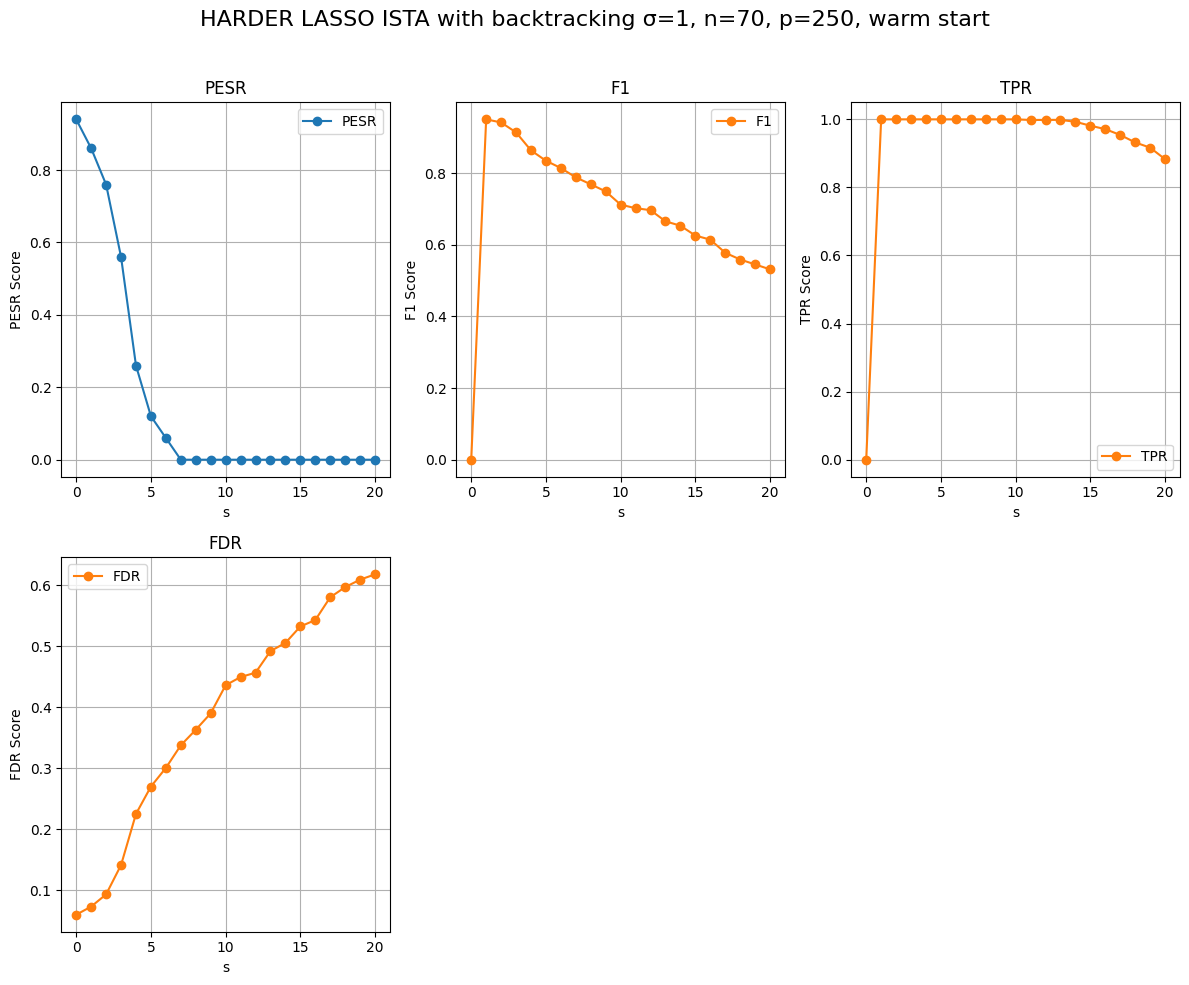

In [61]:
Sim1 = SimulationHarderLasso(
    n = n,
    p = p,
    list_s = list_s,
    sigma = sigma,
    simu_iter = simu_iter,
    qut_iter = qut_iter,
    max_iter = max_iter,
    tol = tol,
    seed = seed,
    verbose=False
)

Sim1.L0 = 1
Sim1.beta0 = 3

Sim1.run()

Sim1.plot()

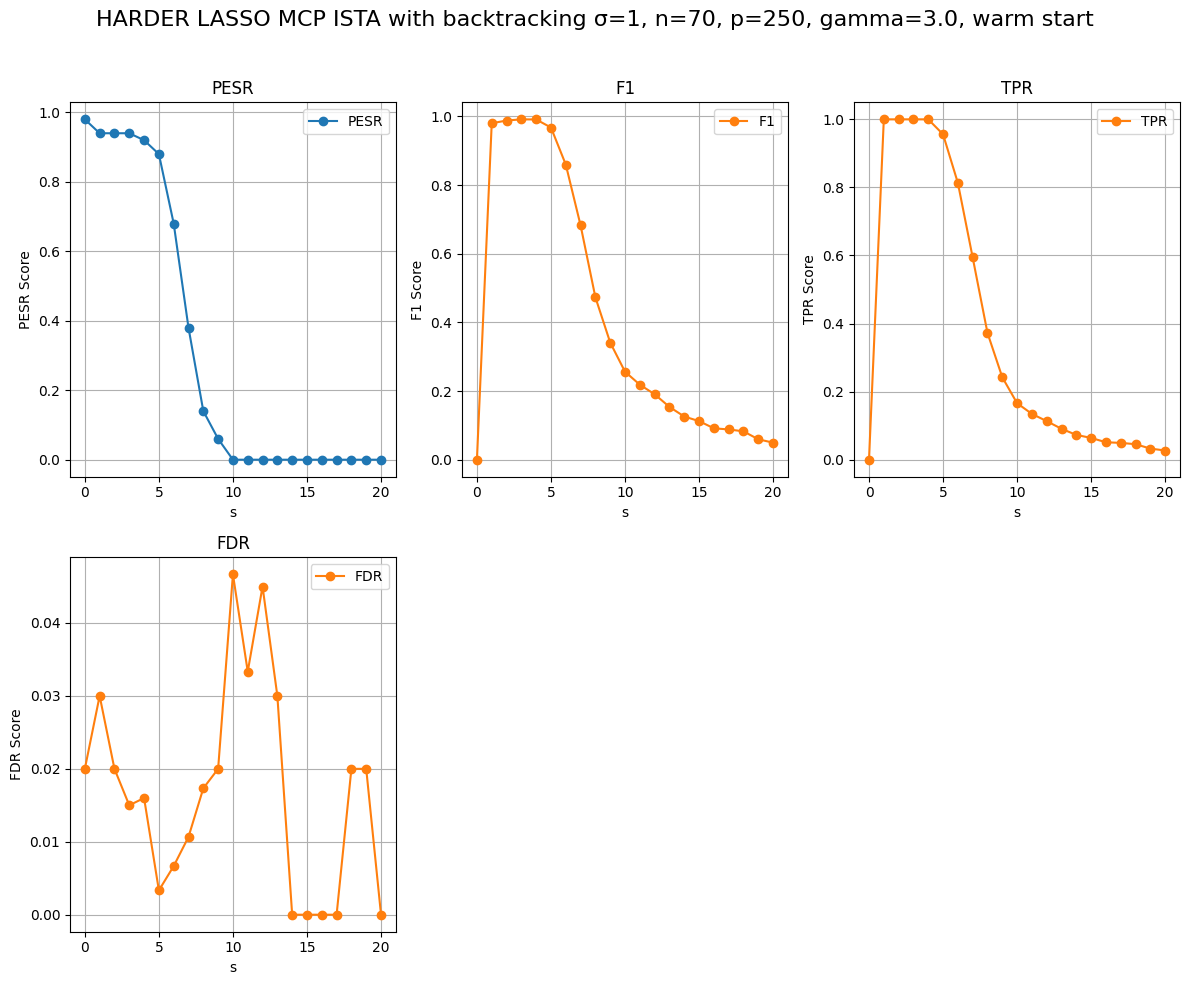

In [62]:
Sim2 = SimulationHarderLassoMCP(
    n = n,
    p = p,
    list_s = list_s,
    sigma = sigma,
    gamma = gamma,
    simu_iter = simu_iter,
    qut_iter = qut_iter,
    max_iter = max_iter,
    tol = tol,
    seed = seed,
    verbose=False
)

Sim2.L0 = 1
Sim2.beta0 = 3

Sim2.run()

Sim2.plot()

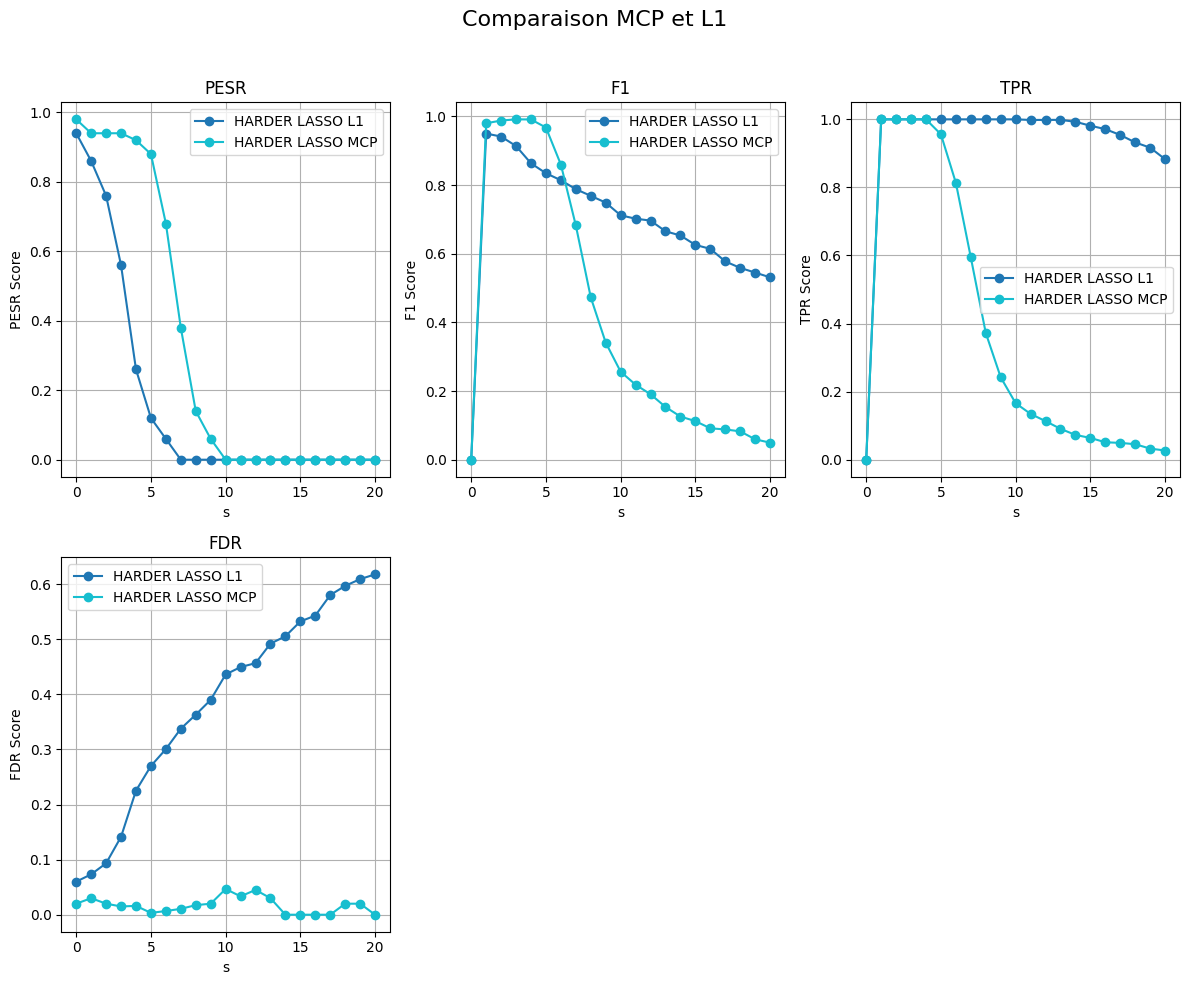

In [63]:
from linear_tools import plot_simulations

simulations = {
    'HARDER LASSO L1': Sim1.score,
    'HARDER LASSO MCP': Sim2.score
}

plot_simulations(simulations, Sim1.list_s, "Comparaison MCP et L1")